### Figures for article 'Is the Fate of Deep Convective Systems written form the start?'

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import joblib
from scipy.stats import gaussian_kde
from scipy.stats import percentileofscore
import cartopy.crs as ccrs
import xarray as xr
from sklearn.preprocessing import StandardScaler


/home/b/b381993/miniconda3/envs/pytorch2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 14})

In [3]:
path_figures = '/home/b/b381993/DeepFate/figures_pnas'

In [4]:
def get_images_from_mcs_idx(mcs_idx, list_var, with_labels=False):
    mcs, utime_list, lat_list, lon_list, label_mcs = list_valid_mcs_2[mcs_idx], utc_list_all[mcs_idx], lat_list_all[mcs_idx], lon_list_all[mcs_idx], label_all[mcs_idx]
    
    X_all = np.zeros((len(list_var), len(utime_list), 128,128))
    
    for idx_time in range(len(utime_list)):
        path_dyamond_dir_utc_time = generate_dyamond_file_path_from_utc(utime_list[idx_time], df_relation_table_UTC=df_relation_table)
        path_toocan_file_utc_time = generate_img_seg_file_path_from_utc(utime_list[idx_time], df_relation_table_UTC=df_relation_table)
        lat, long =  lat_list[idx_time], lon_list[idx_time] 
        for i_var, var in enumerate(list_var):
            if var =='MCS_segmentation_mask_only' : 
                    file_path = os.path.join(DeepDyamond.config.PATH_SEGMENTED_IMGS, path_toocan_file_utc_time)
                    X = open_xarray_rolling_lon(file_path = file_path, 
                                                lat_bary = lat, 
                                                lon_bary = long, 
                                                lat_delta = lat_delta_degrees, 
                                                lon_delta = lon_delta_degrees, 
                                                output_shape = (lat_delta_pixels, lon_delta_pixels),
                                                keys_sel=('latitude', 'longitude'))
                    
                    X = binary_segmentation_mask_processing(data = X, label = label_mcs, transparency=True)
                    X=np.mod(X,15)
            elif var =='MCS_segmentation' :
                    file_path = os.path.join(DeepDyamond.config.PATH_SEGMENTED_IMGS, path_toocan_file_utc_time)
                    X = open_xarray_rolling_lon(file_path = file_path, 
                                                lat_bary = lat, 
                                                lon_bary = long, 
                                                lat_delta = lat_delta_degrees, 
                                                lon_delta = lon_delta_degrees, 
                                                output_shape = (lat_delta_pixels, lon_delta_pixels),
                                                keys_sel=('latitude', 'longitude'))
                    X[X==0]=np.nan
                    #X[X==1]=label_mcs
                    if not with_labels:
                        X=np.mod(X,15)
                    else:
                        None
                    
            else:
                    file_path = os.path.join(DeepDyamond.config.PATH_DYAMOND_ROOT_DIR,path_dyamond_dir_utc_time +'.'+var+'.nc')
                    X = open_xarray_rolling_lon(file_path = file_path, 
                            lat_bary = lat, 
                            lon_bary = long, 
                            lat_delta = lat_delta_degrees, 
                            lon_delta = lon_delta_degrees, 
                            output_shape = (lat_delta_pixels, lon_delta_pixels),
                            keys_sel=('lat', 'lon'))
                    
                    
            X_all[i_var, idx_time, :,:]= X
            
    return X_all
                    

In [5]:
import h5py
filename = '/work/bb1153/b381993/data/FINAL_VERSION_AUGUST_new/DEEPFATE_DATASET.h5'
index=500
with h5py.File(filename, 'r') as f:
    images_i = f['X'][index]
    specs_i = f['z'][index]

In [6]:
X_all = images_i

In [7]:
VARIABLE_PLOT = 'PW'
FULL_NAME_VARIABLE = 'Precipitable Water [mm]'
LATITUDE_SLICE = slice(-40, 40) #degrees
LONGITUDE_SLICE = slice(0, 359)
var = VARIABLE_PLOT
lat_slice = LATITUDE_SLICE
lon_slice=LONGITUDE_SLICE
ROLLING_PIXELS_LON = 4608 #9216/2 corresponds to 180 to be centered to 0°
LON_1, LON_2, LAT_1, LAT_2 = (0.01952, 359.98047, -39.995008, 39.995008)
IMG_EXTENT = ( LON_1-180, LON_2-180, LAT_2, LAT_1)
MODULO_MCS_SEG = 15
COLORBAR_TICKS = np.arange(10,71,1)
CMAP_MCS = plt.cm.get_cmap('gist_ncar', 16)



In [8]:
from DeepFate import config

In [9]:
def get_data_dyamond_toocan(i:int, path_relation_table = config.PATH_RELATION_TABLE):

    rel_table = pd.read_csv(config.PATH_RELATION_TABLE).sort_values(by='UTC_sec')

    UTC = rel_table.iloc[i]['UTC_sec']
    path_dyamond = rel_table.iloc[i]['path_dyamond']
    img_seg_path = rel_table.iloc[i]['img_seg_path']


    path_file_dyamond_pw = os.path.join(config.PATH_DYAMOND_ROOT_DIR, path_dyamond)+'.'+var+'.2D.nc'
    path_file_toocan = os.path.join(config.PATH_SEGMENTED_IMGS, img_seg_path)
    
    PW_dyamond = xr.open_dataarray(path_file_dyamond_pw).roll(lon=ROLLING_PIXELS_LON).sel(lat=lat_slice, lon=lon_slice)[0]
    PW_np = PW_dyamond.values
    
    img_seg = xr.open_dataset(path_file_toocan).cloud_mask.roll(longitude=4608).sel(latitude = lat_slice, longitude=slice(0,360))[0]
    img_seg_np = img_seg.values
    img_seg_np_mod = np.mod(img_seg_np,MODULO_MCS_SEG)
    
    return PW_np, img_seg_np_mod


In [54]:
i_time = 2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from matplotlib.gridspec import GridSpec

fig = plt.figure(layout="constrained",  figsize=(16,9))

gs = GridSpec(140, 60, figure=fig)

ax1 = fig.add_subplot(gs[100:, :10])
ax2 = fig.add_subplot(gs[100:, 10:20])
ax3 = fig.add_subplot(gs[100:, 20:30])
ax4 = fig.add_subplot(gs[100:, 30:40])
ax5 = fig.add_subplot(gs[100:, 40:50])
ax6 = fig.add_subplot(gs[100:, 50:60])

ax = fig.add_subplot(gs[:97, :], projection=ccrs.PlateCarree())





cmap_list=['rainbow',  'PuBu', 'GnBu','Spectral_r', 'Greys', 'PuBuGn',  'Spectral'] #'GnBu', 'cividis_r']

title_list=['DCSs','RH 500Pa [1]',  'IWP [kg/m$^2$]','T surf [K]','LWNTA [W/m$^2$]','OM 700hPa [Pa/s]' ]#'PW [kg/m$^2$]',  'RH 500hPa [1]', 'OM 700hPa [Pa/s]', 'U surf [m/s]',  ]


list_var = ['MCS_segmentation_mask_only',
            'MCS_segmentation',
           'IWP.2D', 
           'T2mm.2D',]

for i,(iv, axx) in enumerate(zip([0,3, 6,5,1,11],[ax1, ax2, ax3, ax4, ax5, ax6])):
    """    
    j=i%4
    
    if i<4:
        k=0
    elif 3<i<8:
        k=1
    """     
   # print(k,j)
    scalebar = AnchoredSizeBar(axx.transData,
                           30, '100km', 'lower center', 
                           pad=1,
                           color='k',
                           frameon=False,
                           size_vertical=1,
                           )
    
    if title_list[i]=='Neighbours':
        map_X = X_all[i_time,iv,:,:]%10
        im = axx.contourf(map_X, 30, cmap=cmap_list[i], alpha=0.8)
        im2 = axx.contourf(X_all[0, i_time,:,:], 30, cmap=cmap_list[i])
        
    elif iv==11:
        vmin_im, vmax_im = -10, 10
        im = axx.contourf(X_all[i_time,iv,:,:], 30, cmap=cmap_list[i], vmin=vmin_im, vmax=vmax_im)

    else:
        vmin_im, vmax_im = np.min(X_all[i_time,iv,:,:]), np.max(X_all[i_time,iv,:,:])
        im = axx.contourf(X_all[i_time,iv,:,:], 30, cmap=cmap_list[i])

    vmin_im2, vmax_im2 = np.min(X_all[i_time,iv,:,:]), np.max(X_all[i_time,iv,:,:])
    t = np.linspace(vmin_im2, vmax_im2, 3)
    axx.add_artist(scalebar)
    axx.set_xticks([])
    axx.set_yticks([])
    axx.set_title(title_list[i], fontstyle='italic')
    
    
    
    if (title_list[i]!='DCSs') and (title_list[i]!='Neighbours'):
        
        #divider = make_axes_locatable(ax[k,j])
        #cax = divider.append_axes('bottom', size='5%')#, pad=0.05)
        im.set_clim(vmin_im, vmax_im)
        cb = fig.colorbar(im, ax=axx, orientation='horizontal',  ticks=t, aspect=20, shrink=0.7, format='%.1f')

    axx.set_aspect('equal')
    

#path_figures = '/work/bb1153/b381993/Figures_for_mcs_dyamond_paper'   
#path_fig = os.path.join(path_figures, 'example_window_sys_variables.pdf')
#plt.savefig(path_fig)



############ bottom plot

#get data
i_0=1000
PW_np, img_seg_np_mod = get_data_dyamond_toocan(i= i_0, path_relation_table = config.PATH_RELATION_TABLE)


#create artists
im = ax.contourf(PW_np, COLORBAR_TICKS, origin='upper', extent=IMG_EXTENT,transform=ccrs.PlateCarree(),cmap='PuBu', vmin=10, vmax=70)

im2 = ax.contourf(img_seg_np_mod, origin='upper', extent=IMG_EXTENT, transform=ccrs.PlateCarree(),cmap = CMAP_MCS)
ax.coastlines(resolution='110m',color='black', linewidth=0.8)

#create colorbar
cb=plt.colorbar(im, shrink=0.5, aspect=100, orientation='horizontal', pad = 0.1, ticks=COLORBAR_TICKS[::10])
cb.set_label(label=f'{FULL_NAME_VARIABLE}', fontstyle='italic')

#add grid_lines
gl = ax.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False


# Assuming you have your axes already created as ax1, ax2, and ax3
labels = ['A','B.', 'C.', 'D.', 'E.', 'F.', 'G.']
pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
pnas_text_color = '#0033a0'  # PNAS dark blue color for text

for i, ax_subi in enumerate([ax, ax1, ax2, ax3, ax4, ax5, ax6]):

    if ax_subi==ax:
        ax_subi.text(
        0.01, 0.93, labels[i], 
        transform=ax_subi.transAxes, 
        weight='bold',
        color=pnas_text_color,  # Text color
        bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
    )
    else:  
        ax_subi.text(
            0.035, 0.9, labels[i], 
            transform=ax_subi.transAxes, 
            weight='bold',
            color=pnas_text_color,  # Text color
            bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
        )

path_to_save = os.path.join(path_figures, 'figure_1.png')
plt.savefig(path_to_save)

In [11]:
from DeepFate.datasets.generate_precomputed_datasets import get_specs_mcs, get_z_data
from DeepFate.datasets.utils import get_list_valid_mcs
from DeepFate.datasets.utils import get_validity_lifecycles_start_end


import DeepFate
from DeepFate import config
from DeepFate.datasets.load_toocan_dyamond import load_TOOCAN_DYAMOND

list_object_mcs = load_TOOCAN_DYAMOND(DeepFate.config.PATH_TOOCAN_GLOBAL_FILE)

list_valid_mcs = get_list_valid_mcs(list_object_mcs = list_object_mcs,
                   max_area=DeepFate.config.MCS_SPECS_RANGE['max_area'][1],
                    min_area=DeepFate.config.MCS_SPECS_RANGE['max_area'][0],
                    duration_max = DeepFate.config.MCS_SPECS_RANGE['duration_hour'][1], #now in hours
                    duration_min = DeepFate.config.MCS_SPECS_RANGE['duration_hour'][0],
                    lat_max=DeepFate.config.MAX_LAT_TROPICS,
                    )

print(len(list_valid_mcs))
validitity, start_times, end_times = get_validity_lifecycles_start_end(list_valid_mcs)
list_valid_mcs_2 = [list_valid_mcs[i] for i in range(len(list_valid_mcs)) if validitity[i] is True]
list_start_times = [start_times[i] for i in range(len(list_valid_mcs)) if validitity[i] is True]
list_end_times = [end_times[i] for i in range(len(list_valid_mcs)) if validitity[i] is True]

print(len(list_valid_mcs_2))


100%|██████████| 63383/63383 [00:00<00:00, 125663.16it/s]


34617


100%|██████████| 34617/34617 [00:01<00:00, 22966.35it/s]

22405


In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import DeepFate

In [12]:
DeepFate.config.PATH_TOOCAN_GLOBAL_FILE

'/work/bb1153/b381993/data3/data/new_TOOCAN-GLOBAL-20160801-20160831.dat.gz'

In [13]:
from DeepFate.datasets.generate_precomputed_datasets import get_specs_mcs, get_z_data
from DeepFate.datasets.utils import get_list_valid_mcs
from DeepFate.datasets.utils import get_validity_lifecycles_start_end


import DeepFate
from DeepFate import config
from DeepFate.datasets.load_toocan_dyamond import load_TOOCAN_DYAMOND

list_object_mcs = load_TOOCAN_DYAMOND(DeepFate.config.PATH_TOOCAN_GLOBAL_FILE)

list_valid_mcs = get_list_valid_mcs(list_object_mcs = list_object_mcs,
                   max_area=DeepFate.config.MCS_SPECS_RANGE['max_area'][1],
                    min_area=DeepFate.config.MCS_SPECS_RANGE['max_area'][0],
                    duration_max = DeepFate.config.MCS_SPECS_RANGE['duration_hour'][1], #now in hours
                    duration_min = DeepFate.config.MCS_SPECS_RANGE['duration_hour'][0],
                    lat_max=DeepFate.config.MAX_LAT_TROPICS,
                    )

print(len(list_valid_mcs))
validitity, start_times, end_times = get_validity_lifecycles_start_end(list_valid_mcs)
list_valid_mcs_2 = [list_valid_mcs[i] for i in range(len(list_valid_mcs)) if validitity[i] is True]
list_start_times = [start_times[i] for i in range(len(list_valid_mcs)) if validitity[i] is True]
list_end_times = [end_times[i] for i in range(len(list_valid_mcs)) if validitity[i] is True]

print(len(list_valid_mcs_2))


100%|██████████| 223648/223648 [00:02<00:00, 110975.10it/s]


72965


100%|██████████| 72965/72965 [00:02<00:00, 24602.63it/s]

46508


In [14]:
print('total dcs', 223648 + 63383)
print('1st filter', 72965 + 34617)
print('active', 46508+22405)

total dcs 287031
1st filter 107582
active 68913


In [15]:
def get_specs_mcs2(object_mcs, start_time, end_time):
    
    nb_timesteps = DeepFate.config.NB_TIMESTEPS # 6 but previously 10
    
    if (end_time - start_time)<(nb_timesteps-1):
        print('ERROR no')
    
    if len(object_mcs.clusters.LC_UTC_time) < nb_timesteps:
        raise ValueError(' len(object_mcs.clusters.Utime) <= nb_timestep')
    
    if len(object_mcs.clusters.LC_lon) < nb_timesteps:
        raise ValueError(' len(object_mcs.clusters.Utime) <= nb_timestep')
    
    duration_mcs = (int(end_time) - int(start_time) + 1 )*0.5 # in hours
    idx_max = np.argmax(object_mcs.clusters.LC_surfkm2_235K)
    if not start_time<idx_max<end_time:
        print('ERROR', start_time, idx_max, end_time)
        raise ValueError('max not in start -> end')
        
    max_extend = np.sqrt(np.max(object_mcs.clusters.LC_surfkm2_235K))
    
    idx_max_extension = np.argmax(object_mcs.clusters.LC_surfkm2_235K)
    delta_time_max_extension = (int(idx_max_extension) - int(start_time))/2
    
    dict_specs_mcs = {'label_toocan_mcs':object_mcs.DCS_number,
                        'utc_list_mcs':object_mcs.clusters.LC_UTC_time[start_time:end_time],
                        'lat_list_mcs':object_mcs.clusters.LC_lat[start_time:end_time],
                        'lon_list_mcs':object_mcs.clusters.LC_lon[start_time:end_time],
                        'surf_km_list_mcs':object_mcs.clusters.LC_surfkm2_235K[start_time:end_time],
                        'duration_mcs':duration_mcs,
                        'average_velocity':object_mcs.clusters.LC_velocity[start_time:end_time],
                        'classif_JIRAK' : object_mcs.INT_classif_JIRAK,
                        'dist' : object_mcs.INT_distance,
                      'max_extend' : max_extend,
                      'delta_time_maximal_extension' : delta_time_max_extension
                     }
    if object_mcs.DCS_number<100:
        raise ValueError(f'{dict_specs_mcs}')
    assert len(set([len(dict_specs_mcs['utc_list_mcs']),
                   len(dict_specs_mcs['lat_list_mcs']),
                   len(dict_specs_mcs['lon_list_mcs']),
                   len(dict_specs_mcs['surf_km_list_mcs'])])) == 1

    return dict_specs_mcs

In [16]:
df_train = pd.read_csv('/work/bb1153/b381993/data/FINAL_VERSION_new/train_dataset.csv')
df_test = pd.read_csv('/work/bb1153/b381993/data/FINAL_VERSION_new/test_dataset.csv')

In [17]:
duration_list, surf_list = df_train['y_duration'], df_train['y_max_extend']

x=duration_list
y = surf_list
xy = np.vstack([x,y])
z_train = gaussian_kde(xy)(xy)


In [18]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(layout="constrained",  figsize=(8,15))

gs = GridSpec(20,10, figure=fig)

ax1 = fig.add_subplot(gs[ :7, :-2])
ax_histx = fig.add_subplot(gs[ 7:9, :-2])
ax = fig.add_subplot(gs[9:-4, :-2])
ax_histy = fig.add_subplot(gs[9:-4, -2:])
cbax = fig.add_subplot(gs[-2:-1,:-2])



######## top panel
cmap_ax1 = plt.get_cmap('GnBu')
for mcs_idx in range(300,400):
    color = (mcs_idx-300)/(400-300)
    mcs, start_time, end_time = list_valid_mcs_2[mcs_idx], list_start_times[mcs_idx], list_end_times[mcs_idx]
    dict_mcs = get_specs_mcs2(object_mcs=mcs, start_time= start_time, end_time= end_time)

    list_area = dict_mcs['surf_km_list_mcs']
    list_area =list_area / np.max(list_area)
    x_axis = np.linspace(0,1, len(list_area))
    
    ax1.plot(np.linspace(0,0.5,10), np.linspace(0,1,10), c='k')
    ax1.plot(np.linspace(0.5,1,10), np.linspace(1,0,10), c='k')
    
    ax1.hlines(1,0,0.5, linestyle='dashed', color='tab:blue')
    ax1.vlines(0.5,0,1, linestyle='dashed', color='tab:red')
    ax1.hlines(0,0,1, linestyle='dashed', color='tab:orange')
    
    
    ax1.text(0,0.9, r'$A_{max}$', color='tab:blue')
    ax1.text(0.35,0.07, r'$t_{max}$', color='tab:red')
    ax1.text(0.65,0.07, r'$D$, total duration', color='tab:orange')
    
    ax1.plot(x_axis, list_area, '.-',c=cmap_ax1(color), linewidth=0.3, ms=0.3)
    ax1.grid(True)

    ax1.set_xlabel('Normalized time evolution [1]')
    ax1.set_ylabel('Normalized Area [1]')
    
    ax1.set_xlim(-0.05,1.05)
    ax1.set_ylim(0,1.05)
    
    
#### bottom panel


m, b = np.polyfit(duration_list, surf_list, 1)

im = ax.scatter(duration_list, surf_list, c=1000*1000*z_train, marker='x', alpha=(z_train/np.max(z_train))**0.5, cmap='YlGnBu_r')
#im = ax.hexbin(duration_list, surf_list, gridsize=30,alpha=0.7, cmap='YlGnBu', vmin=0, vmax=500)
#ax.plot(duration_list, m*np.array(duration_list)+b, color='k', ls='--')
ax.set_xlabel('Duration of MCSs [h]')

ax.set_ylabel(r'$\sqrt{A_{max}}$ [$km$]')
#r = np.round(df_new_with_kde.corr()['duration']['maximal_extension'], 3)
#print(r)
#ax.text(37, 35000, f'r = {r}', color='k')
ax.grid(True)


color=plt.get_cmap('RdYlBu')(0.98)

n, bins, patches = ax_histx.hist(df_train['y_duration'], bins=np.linspace(min(df_train['y_duration']), 22, 35), facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
 
n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.YlGnBu_r(n[i]/max(n)))
    #patches[i].set_facecolor(plt.cm.YlGnBu_r(n[i]/np.sum(n)))
    
n, bins, patches = ax_histy.hist(df_train['y_max_extend'], bins=np.linspace(min(df_train['y_max_extend']), max(df_train['y_max_extend']), 60), facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7, orientation='horizontal')

n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.YlGnBu_r(n[i]/max(n)))
    
#ax_histy.hist(surf_list, bins=20, orientation='horizontal', alpha=0.7, rwidth=0.85, color=color)
ax_histx.spines[['right', 'top']].set_visible(False)
ax_histy.spines[['right', 'top']].set_visible(False)




fig.colorbar(im, orientation='horizontal', label=r'Density [$10^{-3}$]', aspect=110, ax=cbax)

cbax.remove()

ax_histx.set_xticks([])
ax_histy.set_yticks([])


ax.set_xlim(4,18)
ax_histx.set_xlim(4,18)

ax.set_ylim(40,250)
ax_histy.set_ylim(40,250)


# Assuming you have your axes already created as ax1, ax2, and ax3
labels = ['A.', 'B.']
pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
pnas_text_color = '#0033a0'  # PNAS dark blue color for text

for i, ax_subi in enumerate([ax1, ax]):
    ax_subi.text(
        0.02, 0.93, labels[i], 
        transform=ax_subi.transAxes, 
        weight='bold',
        color=pnas_text_color,  # Text color
        bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
    )

path_to_save = os.path.join(path_figures, 'figure_6.pdf')
plt.savefig(path_to_save)

In [19]:
df_train = pd.read_csv('/work/bb1153/b381993/data/FINAL_VERSION_new/train_dataset.csv')
df_test = pd.read_csv('/work/bb1153/b381993/data/FINAL_VERSION_new/test_dataset.csv')
df_names=pd.read_csv('/home/b/b381993/DeepFate/notebooks/name_dict.csv')

In [20]:
len(df_train) + len(df_test)

68913

In [21]:
nb_timesteps=3

In [22]:
def get_X_cols(columns, nb_timesteps):
    output_cols_1 = []
    for col in columns:
        if any([col.endswith(f'time_{i}') for i in range(nb_timesteps)]):
            output_cols_1.append(col)
            
    
    return output_cols_1

def get_one_feature(df, feature_name):
    output_col = []
    for col in df.columns:
        if col.startswith(f'{feature_name}'):
            output_col.append(col)

    return output_col

import DeepFate
from DeepFate.model.utils_model import get_model
import os

def get_features_importance(path_model, model_str, df_train, nb_timesteps):
    path_file = os.path.join(path_model,f'{model_str}_ALL_FEATURES_{nb_timesteps}.joblib')
    model = get_model(model_str)
    model = joblib.load(path_file)
    
    if model_str=='Lasso':
        feature_importances = model.coef_
        feature_importances_abs = np.abs(model.coef_)
    elif model_str=='RandomForest':
        feature_importances = model.feature_importances_
        feature_importances_abs = np.abs(model.feature_importances_)
        
    index_argsort = np.argsort(feature_importances_abs)[::-1]
    values_features = feature_importances[index_argsort]
    
    columns_cut = get_X_cols(df_train.columns, nb_timesteps=nb_timesteps)
    df_train_cut = df_train[columns_cut]
    features_selected_names = df_train_cut.columns[index_argsort]
    
    return features_selected_names, values_features, index_argsort

def plot_features_importance(model_str, nb_selected, path_model, df_train, nb_timesteps, automatic_name:bool=False):
    features_selected_names, values_features, index_argsort = get_features_importance(path_model='/work/bb1153/b381993/data/FINAL_VERSION_new/saved_models/',
                        model_str=model_str,
                        df_train=df_train,
                        nb_timesteps=nb_timesteps)

    fig = plt.figure(figsize=(10,6), constrained_layout=True)

    sel_features = features_selected_names[:nb_selected][::-1]
    y_pos = np.arange(len(sel_features))

    performance = values_features[:nb_selected][::-1]

    plt.barh(y_pos, performance, align='center', color=plt.get_cmap('Spectral')(0.85))


    labels= [df_names[df_names['Old Name']==sel_features[i]]['Name Plot'].values[0] for i in range(15)]

    plt.yticks(y_pos, labels=labels)

    #plt.invert_yaxis()  # labels read top-to-bottom
    plt.xlabel('Coefficients')
    plt.title(f'Important Features and attributed coefficients for {model_str}', fontstyle='italic')
    plt.grid(True)


    plt.tight_layout()
    plt.show()


In [23]:
import pandas as pd
import os
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import pearsonr
from tqdm import tqdm
import joblib
from scipy.stats import gaussian_kde
from scipy.stats import percentileofscore
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from tqdm import tqdm
import argparse
from matplotlib.gridspec import GridSpec


In [24]:
folder_path = '/work/bb1153/b381993/data/FINAL_VERSION_new/'
folder_path_preds = os.path.join(folder_path, 'saved_preds')
path_to_preds_df = os.path.join(folder_path_preds, 'preds_all_models_all_features.parquet')
df_all_features=pd.read_parquet(path_to_preds_df)

In [25]:
############ GET WHERE STATS ARE
folder_path_stats = os.path.join(folder_path, 'saved_stats')
all_features_stats_files = [f for f in os.listdir(folder_path_stats) if 'all_features' in f]
only_growth_rate_stats_files = [f for f in os.listdir(folder_path_stats) if 'only_growth' in f]


##########LOAD STATS
df_all_features_stats = pd.read_csv(os.path.join(folder_path_stats,all_features_stats_files[0]))
df_only_growth_rate_stats = pd.read_csv(os.path.join(folder_path_stats,only_growth_rate_stats_files[0]))


####lsit of stats
list_pearsonr_only_growth_rate=[]
list_rmse_only_growth_rate=[]
for model_str in ['Lasso', 'RandomForest', 'MLPRegressor']:
    pearsonr_list=[]
    rmse_list=[]
    for i_t in range(DeepFate.config.NB_TIMESTEPS):
        model_t = f'{model_str}_{i_t}'
        pearsonr_list.append(df_only_growth_rate_stats[df_only_growth_rate_stats['model']==model_t]['pearsonr'].values)
        rmse_list.append(df_only_growth_rate_stats[df_only_growth_rate_stats['model']==model_t]['rmse'].values)
    
                  
    list_pearsonr_only_growth_rate.append(pearsonr_list)
    list_rmse_only_growth_rate.append(rmse_list)
    
list_pearsonr_all_features=[]
list_rmse_all_features=[]
for model_str in ['Lasso', 'RandomForest', 'MLPRegressor']:
    pearsonr_list=[]
    rmse_list=[]
    for i_t in range(DeepFate.config.NB_TIMESTEPS):
        model_t = f'{model_str}_{i_t}'
        pearsonr_list.append(df_all_features_stats[df_only_growth_rate_stats['model']==model_t]['pearsonr'].values)
        rmse_list.append(df_all_features_stats[df_only_growth_rate_stats['model']==model_t]['rmse'].values)
    

    list_pearsonr_all_features.append(pearsonr_list)
    list_rmse_all_features.append(rmse_list)


##########PLOT


fig, ax = plt.subplots(2,1, figsize=(7,12), constrained_layout=True)
cmap_color=plt.get_cmap('PuBuGn')
color_rmse = cmap_color(0.6)
color_r = cmap_color(0.99)



legend_elements = [Line2D([0], [0], color='k', lw=1,linestyle='-', label='Lasso'),
                    Line2D([0], [0], color='k', lw=1,linestyle='--', label='Random Forest'),
                  Line2D([0], [0], color='k', lw=1,linestyle='-.', label='MLP')]


#######top
ax2 = plt.twinx(ax[0])

label_list = ['Lasso','Random Forest','MLP']
linestyle_list = ['-', '--', '-.']
i=0

x = ['0.5', '1', '1.5', '2', '2.5', '3','3.5','4','4.5','5']

for list_rmse, list_pearson in zip(list_rmse_only_growth_rate, list_pearsonr_only_growth_rate):
    label=label_list[i]
    ax[0].plot(x,list_rmse, linestyle_list[i], color=color_rmse)
    ax2.plot(x,list_pearson,  linestyle_list[i], color=color_r)
    ax2.plot([], [], linestyle_list[i], label=label, color=color_r)
    i=i+1


ax[0].set_xticks(['0.5', '1', '1.5', '2', '2.5', '3','3.5','4','4.5','5'])

ax2.yaxis.label.set_color(color_r)
ax2.tick_params(axis='y', colors=color_r)

ax[0].yaxis.label.set_color(color_rmse)
ax[0].tick_params(axis='y', colors=color_rmse)

ax[0].hlines(np.sqrt(np.var(df_train['y_max_extend'])), 0.5, 8.5, linestyle='dotted')

ax[0].set_ylim(3,33)
ax2.set_ylim(0,1)

ax[0].grid(True)

plt.legend(handles=legend_elements,loc='upper center', borderaxespad=-3, ncol=3)

ax[0].set_xlabel('Time of Observation [h]')
ax[0].set_ylabel(r'Root Mean Square error [$km$]')
ax2.set_ylabel(r'Pearson-r regression score [1]')

ax2.set_ylim(0,1)
ax[0].set_ylim(5,45)

ax[0].text(5.5, 25.0, 'Only Growth Rate', style='italic', bbox={'facecolor': 'tab:blue', 'alpha': 0.3, 'pad': 10})


######### bottom

label_list = ['Lasso', 'Random Forest','MLP']
linestyle_list = ['-', '--', '-.']
i=0

x = ['0.5', '1', '1.5', '2', '2.5', '3','3.5','4','4.5','5']

ax3 = plt.twinx(ax[1])


for list_rmse, list_pearson in zip(list_rmse_all_features, list_pearsonr_all_features):
    label=label_list[i]
    ax[1].plot(x,list_rmse, linestyle_list[i], color=color_rmse)
    ax3.plot(x,list_pearson,  linestyle_list[i], color=color_r)
    ax3.plot([], [], linestyle_list[i], color='k')
    i=i+1

i=-1
for list_rmse, list_pearson in zip(list_rmse_all_features, list_pearsonr_all_features):
    label=label_list[i]
    ax[1].plot(x,list_rmse, linestyle_list[i], color=color_rmse, alpha=0.5)
    ax3.plot(x,list_pearson,  linestyle_list[i], color=color_r, alpha=0.5)
    ax3.plot([], [], linestyle_list[i], color='k')
    i=i+1


ax[1].plot(x,list_rmse_only_growth_rate[0],color='grey', alpha=0.7)
           
ax3.plot(x,list_pearsonr_only_growth_rate[0], color='grey', alpha=0.7)
ax[1].hlines(np.sqrt(np.var(df_train['y_max_extend'])), 0.5, 8.5, linestyle='dotted')
ax[1].set_xlabel('Time of Observation [h]')
ax[1].set_ylabel(r'Root Mean Square error [$km$]')
ax3.set_ylabel(r'Pearson-r regression score [1]')


ax3.set_ylim(0,1)
ax[1].set_ylim(5,45)




ax[1].grid(True)
ax3.yaxis.label.set_color(color_r)
ax3.tick_params(axis='y', colors=color_r)

ax[1].yaxis.label.set_color(color_rmse)
ax[1].tick_params(axis='y', colors=color_rmse)

ax[1].text(5.5, 25.0, 'All features', style='italic', bbox={'facecolor': 'tab:blue', 'alpha': 0.3, 'pad': 10})

# Assuming you have your axes already created as ax1, ax2, and ax3
labels = ['A.', 'B.']
pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
pnas_text_color = '#0033a0'  # PNAS dark blue color for text

for i, ax_subi in enumerate([ax[0], ax[1]]):
    ax_subi.text(
        0.02, 0.93, labels[i], 
        transform=ax_subi.transAxes, 
        weight='bold',
        color=pnas_text_color,  # Text color
        bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
    )


path_to_save = os.path.join(path_figures, 'figure_2.pdf')
plt.savefig(path_to_save)

(2, 17229)


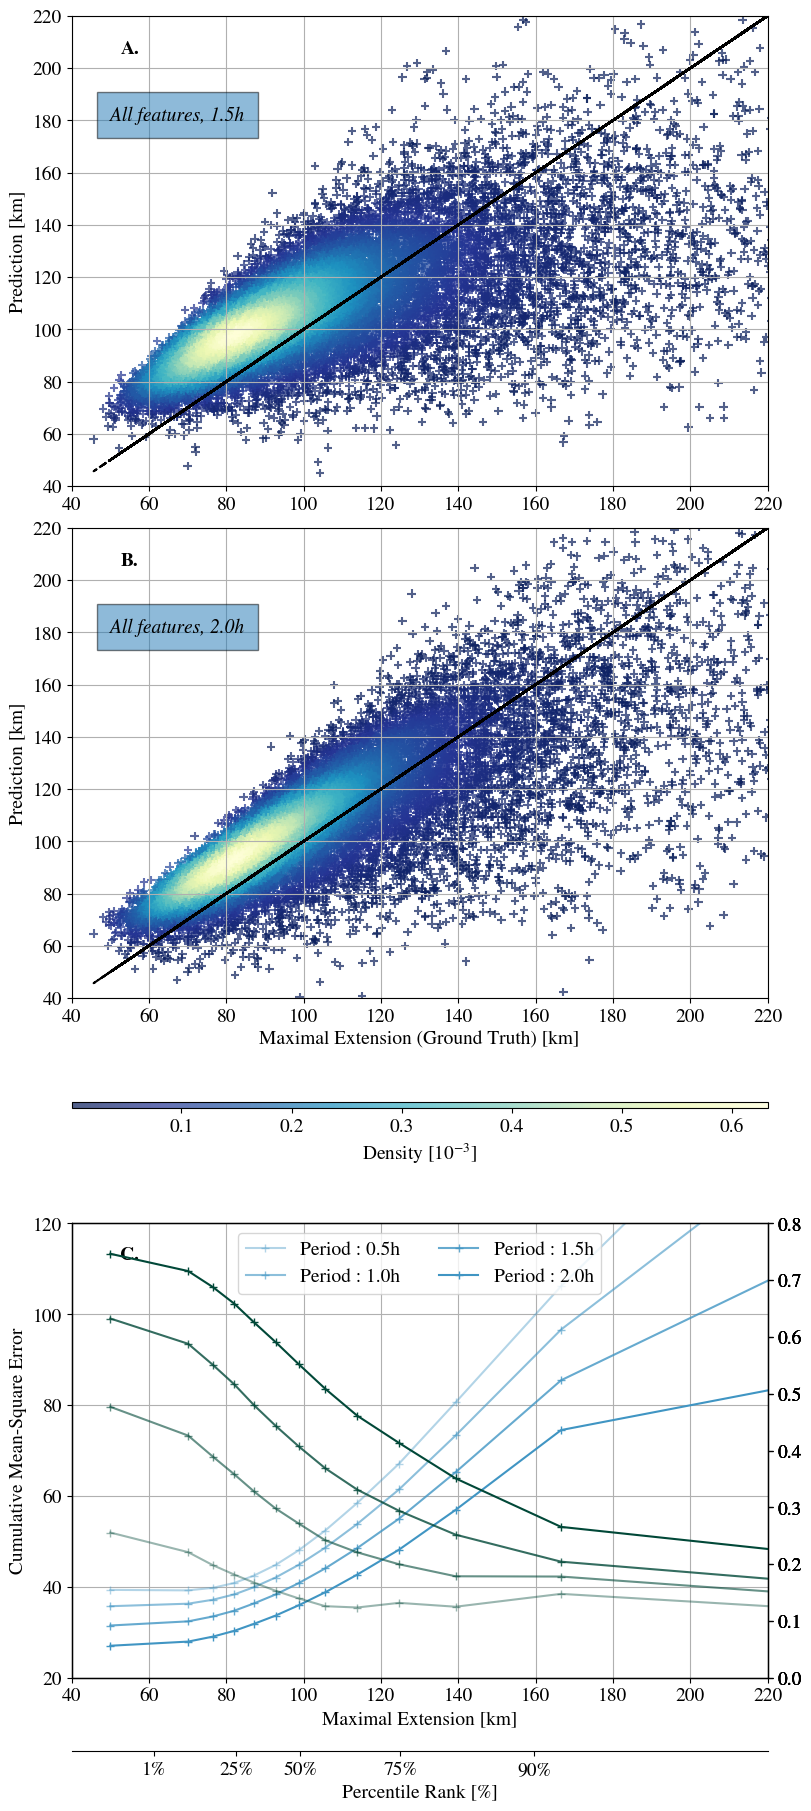

In [26]:
i_model = 0
model_str ='Lasso'

fig = plt.figure(layout="constrained",  figsize=(8,18))

gs = GridSpec(100, 6, figure=fig)

ax1 = fig.add_subplot(gs[:30, :])
ax2 = fig.add_subplot(gs[30:60, :])
ax4 = fig.add_subplot(gs[60:70, :])
ax3 = fig.add_subplot(gs[70:99, :])
ax33 = fig.add_subplot(gs[99:100, :])


#### ax1
nb_timesteps=3
str_dict = f'{model_str}_{nb_timesteps}'

y_preds =df_all_features[df_all_features['model']==str_dict]['preds'].values
y_test =df_all_features[df_all_features['model']==str_dict]['truth'].values


x=y_preds[0]
y = y_test[0]

xy = np.vstack([x,y])
xy=np.array(xy)
z = gaussian_kde(xy)(xy)


im = ax1.scatter( y_test[0],  y_preds[0], marker = '+', c =1000*z, alpha=0.7, cmap='YlGnBu_r')

ax1.set_xlim(40,220)
ax1.set_ylim(40,220)
#plt.title('Multi-Linear Model, all features, 1h', fontstyle='italic')
#ax1.set_xlabel('Maximal Extension (Ground Truth) [km]')
ax1.set_ylabel('Prediction [km]')



ax1.plot(y_test[0], y_test[0], color='k', linestyle='dashed')
#plt.plot(y_test, 1.13*y_test-13.78967328)
ax1.grid(True)
#plt.plot(y_test, y_test)

ax1.text(50, 180, f'All features, {nb_timesteps/2}h', style='italic', bbox={'facecolor': 'tab:blue', 'alpha': 0.5, 'pad': 10})



### ax2
nb_timesteps=4
str_dict = f'{model_str}_{nb_timesteps}'
y_preds =df_all_features[df_all_features['model']==str_dict]['preds'].values
y_test =df_all_features[df_all_features['model']==str_dict]['truth'].values

x=y_preds[0]
y = y_test[0]
xy = np.vstack([x,y])
xy = np.array(xy)

print(xy.shape)

z = gaussian_kde(xy)(xy)


#im = plt.scatter( y_test**2,  0.5*(y_preds_lr**2+y_preds_rf**2), marker = '+', c = df_test['y_duration'], alpha=0.6)
#im = plt.scatter( y_test, 0.5*(y_preds_lr+y_preds_rf), marker = '+', c =z)
im = ax2.scatter( y_test[0],  y_preds[0], marker = '+', c =1000*z, alpha=0.7, cmap='YlGnBu_r')

ax2.set_xlim(40,220)
ax2.set_ylim(40,220)
#plt.title('Multi-Linear Model, all features, 1.5h', fontstyle='italic')
ax2.set_xlabel('Maximal Extension (Ground Truth) [km]')
ax2.set_ylabel('Prediction [km]')

#ax[1].clim(0,0.5)


ax2.plot(y_test[0], y_test[0], color='k', linestyle='dashed')
#plt.plot(y_test, 1.13*y_test-13.78967328)
ax2.grid(True)
#plt.plot(y_test, y_test)

ax2.text(50, 180, f'All features, {nb_timesteps/2}h', style='italic', bbox={'facecolor': 'tab:blue', 'alpha': 0.5, 'pad': 10})

fig.colorbar(im, orientation='horizontal', label=r'Density [$10^{-3}$]', aspect=110, pad=-0.7, ax=ax4)

######## ax3
cmap_color=plt.get_cmap('PuBuGn')
color_rmse = cmap_color(0.6)
color_r = cmap_color(0.99)


rmse_values=[]
rmse_values_list=[]

for nb_timesteps in [1, 2, 3, 4]:
    str_dict = f'{model_str}_{nb_timesteps}'
    y_preds = df_all_features[df_all_features['model']==str_dict]['preds'].values
    y_test =df_all_features[df_all_features['model']==str_dict]['truth'].values

    rmse_values = []
    pearsonr_values =[]

    y_preds = np.array(y_preds[0])
    y_test = np.array(y_test[0])


    cmap=plt.get_cmap('PuBuGn',5)
    N=100
    quantile_size = [np.quantile(y_test, i/N) for i in range(1,N+1)]
    
    N2=12
    quantile_size2 = [np.quantile(y_test, i/N2) for i in range(1,N2+1)]
    quantile_size2.insert(0, 50)

    for size in quantile_size2:
        idx = np.where(y_test >= size)[0]
        rmse_values.append(np.sqrt(mean_squared_error(y_preds[idx], y_test[idx], squared=True)))
        try:
            pearsonr_values.append(pearsonr(y_preds[idx], y_test[idx])[0])
        except:
            pearsonr_values.append(0)
            

    ax3.plot(quantile_size2, rmse_values, '+-', color=color_rmse, label=f'Period : {nb_timesteps*0.5}h', alpha=(nb_timesteps+1)/5)

    ax3_bis=plt.twinx(ax3)
    ax3_bis.plot(quantile_size2, pearsonr_values, '+-', color=color_r, alpha=(nb_timesteps+1)/5)

    #ax33.plot(quantile_size2, rmse_values, alpha=0)
    #ax3.plot(n)#, capsize=4, capthick=2, color=cmap(nb_timesteps), label=f'Period : {nb_timesteps*0.5}h')

    #im2=ax3.scatter(y_test, 100*(np.sqrt((np.mean(y_test)-y_test)**2)/y_test), marker='+', c='k', s=1, label='Constant Prediction')
    #ax3.set_ylim(-5,80)
    
     
    #plt.title('Lasso, only growth rate area', fontstyle='italic')
    
    data = quantile_size
    # Calculate percentiles for ticks
    percentiles_for_ticks = [1,  25, 50, 75, 90, 100]
    
    
    #ax3.vlines(quantile_size2[8],0.15,1, color='k', ls='--')
    # Calculate the values at the specified percentiles
    
    ticks_values = np.percentile(data, percentiles_for_ticks)
    
    # Create a mapping of percentile to clean label
    percentile_label_mapping = {p: f'{p}%' for p in percentiles_for_ticks}
    
    # Calculate the percentile rank for each tick value
    tick_percentile_ranks = [percentileofscore(data, value) for value in ticks_values]
    
    

    ax33.yaxis.set_visible(False) # hide the yaxis
    ax33.set_xticks(ticks_values)
    ax33.set_xticklabels([percentile_label_mapping[p] for p in percentiles_for_ticks])
    
    
    ax3.set_xlim(40,220)
    ax3.set_ylim(20,120)

    ax3_bis.set_xlim(40,220)
    ax3_bis.set_ylim(0,0.8)
    
    
    ax33.set_xlim(40,220)


    
    ax33.spines['top'].set_visible(False)
    ax33.spines['right'].set_visible(False)
    ax33.spines['left'].set_visible(False)
    ax33.spines['bottom'].set_position('zero')
    ax33.set_xlabel('Percentile Rank [%]')
    
    
    ax3.set_xlabel('Maximal Extension [km]')
    ax3.set_ylabel('Cumulative Mean-Square Error')
    ax3.legend(ncol=2,  loc= 'upper center')
    ax3.grid(True)
   
    ax4.set_axis_off()


labels = ['A.', 'B.', 'C.']
for i, ax_subi in enumerate([ax1,ax2, ax3]):
    ax_subi.text(0.07, 0.92, labels[i], transform=ax_subi.transAxes, weight='bold')



path_to_save = os.path.join(path_figures, 'figure_3.pdf')
plt.savefig(path_to_save)

In [27]:
i_model = 0
model_str ='Lasso'

fig = plt.figure(layout="constrained",  figsize=(8,18))

gs = GridSpec(100, 6, figure=fig)

ax1 = fig.add_subplot(gs[:30, :])
ax2 = fig.add_subplot(gs[30:60, :])
ax4 = fig.add_subplot(gs[60:70, :])
ax3 = fig.add_subplot(gs[70:99, :])
ax33 = fig.add_subplot(gs[99:100, :])


#### ax1
nb_timesteps=2
str_dict = f'{model_str}_{nb_timesteps}'

y_preds =df_all_features[df_all_features['model']==str_dict]['preds'].values
y_test =df_all_features[df_all_features['model']==str_dict]['truth'].values


x=y_preds[0]
y = y_test[0]

xy = np.vstack([x,y])
xy=np.array(xy)
z = gaussian_kde(xy)(xy)


im = ax1.scatter( y_test[0],  y_preds[0], marker = '+', c =1000*z, alpha=0.7, cmap='YlGnBu_r')

ax1.set_xlim(40,220)
ax1.set_ylim(40,220)
#plt.title('Multi-Linear Model, all features, 1h', fontstyle='italic')
#ax1.set_xlabel('Maximal Extension (Ground Truth) [km]')
ax1.set_ylabel('Prediction [km]')



ax1.plot(y_test[0], y_test[0], color='k', linestyle='dashed')
#plt.plot(y_test, 1.13*y_test-13.78967328)
ax1.grid(True)
#plt.plot(y_test, y_test)

ax1.text(50, 180, f'All features, {nb_timesteps/2}h', style='italic', bbox={'facecolor': 'tab:blue', 'alpha': 0.5, 'pad': 10})



### ax2
nb_timesteps=3
str_dict = f'{model_str}_{nb_timesteps}'
y_preds =df_all_features[df_all_features['model']==str_dict]['preds'].values
y_test =df_all_features[df_all_features['model']==str_dict]['truth'].values

x=y_preds[0]
y = y_test[0]
xy = np.vstack([x,y])
xy = np.array(xy)

print(xy.shape)

z = gaussian_kde(xy)(xy)


#im = plt.scatter( y_test**2,  0.5*(y_preds_lr**2+y_preds_rf**2), marker = '+', c = df_test['y_duration'], alpha=0.6)
#im = plt.scatter( y_test, 0.5*(y_preds_lr+y_preds_rf), marker = '+', c =z)
im = ax2.scatter( y_test[0],  y_preds[0], marker = '+', c =1000*z, alpha=0.7, cmap='YlGnBu_r')

ax2.set_xlim(40,220)
ax2.set_ylim(40,220)
#plt.title('Multi-Linear Model, all features, 1.5h', fontstyle='italic')
ax2.set_xlabel('Maximal Extension (Ground Truth) [km]')
ax2.set_ylabel('Prediction [km]')

#ax[1].clim(0,0.5)


ax2.plot(y_test[0], y_test[0], color='k', linestyle='dashed')
#plt.plot(y_test, 1.13*y_test-13.78967328)
ax2.grid(True)
#plt.plot(y_test, y_test)

ax2.text(50, 180, f'All features, {nb_timesteps/2}h', style='italic', bbox={'facecolor': 'tab:blue', 'alpha': 0.5, 'pad': 10})

fig.colorbar(im, orientation='horizontal', label=r'Density [$10^{-3}$]', aspect=110, pad=-0.7, ax=ax4)

######## ax3
cmap_color=plt.get_cmap('PuBuGn')
color_rmse = cmap_color(0.6)
color_r = cmap_color(0.99)


rmse_values=[]
rmse_values_list=[]

model_str ='Lasso'
for i,nb_timesteps in enumerate([1,2,3,4]):

    str_dict = f'{model_str}_{nb_timesteps}'
    
    y_preds =df_all_features[df_all_features['model']==str_dict]['preds'].values
    y_test =df_all_features[df_all_features['model']==str_dict]['truth'].values
    
    y_preds=y_preds[0]
    y_test = y_test[0]
    

    yy = 100*(np.sqrt((y_preds-y_test)**2)/y_test)
    xx = df_test['y_max_extend']
    nbins = np.arange(40,240,20)
    n, _ = np.histogram(xx, bins=nbins)
    sy, _ = np.histogram(xx, bins=nbins, weights=yy)
    sy2, _ = np.histogram(xx, bins=nbins, weights=yy*yy)
    mean = sy / n
    std = np.sqrt(sy2/n - mean*mean)

    ax3.errorbar((_[1:] + _[:-1])/2, mean, yerr=std,fmt='+--', color=color_rmse, label=f'Period : {nb_timesteps*0.5}h', alpha=((nb_timesteps+0.5)/4.5)**2,
                capsize=4, capthick=2,)
    
    #plt.clim(0,0.7)
    ax3.set_xlim(40,220)
    ax3.set_ylim(0,60)
    ax3.set_xlabel('Maximal Extension [km]')
    ax3.set_ylabel('RSME relative to the size [%]')
    ax3.grid(True)
    data = quantile_size
    # Calculate percentiles for ticks
    percentiles_for_ticks = [1,  25, 50, 75, 90, 100]
    
    
    #ax3.vlines(quantile_size2[8],0.15,1, color='k', ls='--')
    # Calculate the values at the specified percentiles
    
    ticks_values = np.percentile(data, percentiles_for_ticks)
    
    # Create a mapping of percentile to clean label
    percentile_label_mapping = {p: f'{p}%' for p in percentiles_for_ticks}
    
    # Calculate the percentile rank for each tick value
    tick_percentile_ranks = [percentileofscore(data, value) for value in ticks_values]
    
    

    ax33.yaxis.set_visible(False) # hide the yaxis
    ax33.set_xticks(ticks_values)
    ax33.set_xticklabels([percentile_label_mapping[p] for p in percentiles_for_ticks])
    
    
    ax3.set_xlim(40,220)
    #ax3.set_ylim(20,120)

    ax3_bis.set_xlim(40,220)
    ax3_bis.set_ylim(0,0.8)
    
    
    ax33.set_xlim(40,220)


    
    ax33.spines['top'].set_visible(False)
    ax33.spines['right'].set_visible(False)
    ax33.spines['left'].set_visible(False)
    ax33.spines['bottom'].set_position('zero')
    ax33.set_xlabel('Percentile Rank [%]')
    
    
    ax3.set_xlabel('Maximal Extension [km]')
    ax3.set_ylabel(r'Root Mean Square Error per bin [$\%$]')
    ax3.legend(ncol=2,  loc= 'upper center')
    ax3.grid(True)

    ax3.yaxis.label.set_color(color_rmse)
    ax3.tick_params(axis='y', colors=color_rmse)
   
    ax4.set_axis_off()


# Assuming you have your axes already created as ax1, ax2, and ax3
labels = ['A.', 'B.', 'C.']
pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
pnas_text_color = '#0033a0'  # PNAS dark blue color for text

for i, ax_subi in enumerate([ax1, ax2, ax3]):
    ax_subi.text(
        0.02, 0.93, labels[i], 
        transform=ax_subi.transAxes, 
        weight='bold',
        color=pnas_text_color,  # Text color
        bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
    )

path_to_save = os.path.join(path_figures, 'figure_3.pdf')
plt.savefig(path_to_save)

(2, 17229)


In [28]:
cmap=plt.get_cmap('rainbow',5)
fig, ax = plt.subplots(figsize=(13,5), constrained_layout=True)
model_str ='Lasso'
for i,nb_timesteps in enumerate([3,4]):

    str_dict = f'{model_str}_{nb_timesteps}'
    
    y_preds =df_all_features[df_all_features['model']==str_dict]['preds'].values
    y_test =df_all_features[df_all_features['model']==str_dict]['truth'].values
    
    y_preds=y_preds[0]
    y_test = y_test[0]
    

    
    yy = 100*(np.sqrt((y_preds-y_test)**2)/y_test)
    xx = df_test['y_max_extend']
    nbins = np.arange(40,240,20)
    n, _ = np.histogram(xx, bins=nbins)
    sy, _ = np.histogram(xx, bins=nbins, weights=yy)
    sy2, _ = np.histogram(xx, bins=nbins, weights=yy*yy)
    mean = sy / n
    std = np.sqrt(sy2/n - mean*mean)

    ax.errorbar((_[1:] + _[:-1])/2, mean, yerr=std,fmt='--', capsize=4, capthick=2, color='k')
    
    #plt.clim(0,0.7)
    ax.set_xlim(40,220)
    ax.set_ylim(0,60)
    ax.set_title(f'Multi-linear model, all features, {nb_timesteps/2}h', fontstyle='italic')
    ax.set_xlabel('Maximal Extension [km]')
    ax.set_ylabel('RSME relative to the size [%]')
    ax.grid(True)
    
#cb=fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.6, orientation='horizontal', aspect=110, label=r'Density [$10^{-3}$]')
    


In [29]:
size_threshold = 200

# Model string and number of timesteps
str_dict = f'{model_str}_{nb_timesteps}'

# Extract predictions and truth values
y_preds = df_all_features[df_all_features['model'] == str_dict]['preds'].values
y_test = df_all_features[df_all_features['model'] == str_dict]['truth'].values

# Assuming the predictions and truths are stored in lists or arrays
y_preds = y_preds[0]
y_test = y_test[0]

# Calculate the percentage error
errors = 100 * np.sqrt((y_preds - y_test)**2) / y_test

# Extract the corresponding sizes
xx = df_test['y_max_extend']

# Filter errors and sizes below the threshold
filtered_errors = errors[xx < size_threshold]
filtered_sizes = xx[xx < size_threshold]

# Calculate cumulative error
cumulative_error = np.cumsum(filtered_errors)

# Bin the data and calculate histogram
nbins = np.arange(40, 240, 20)
n, _ = np.histogram(filtered_sizes, bins=nbins)
sy, _ = np.histogram(filtered_sizes, bins=nbins, weights=filtered_errors)
sy2, _ = np.histogram(filtered_sizes, bins=nbins, weights=filtered_errors**2)
mean = sy / n
std = np.sqrt(sy2 / n - mean**2)

# Plot the cumulative error
plt.figure(figsize=(10, 6))
plt.errorbar((_[1:] + _[:-1]) / 2, mean, yerr=std, fmt='--', capsize=4, capthick=2, color='k')

<ErrorbarContainer object of 3 artists>

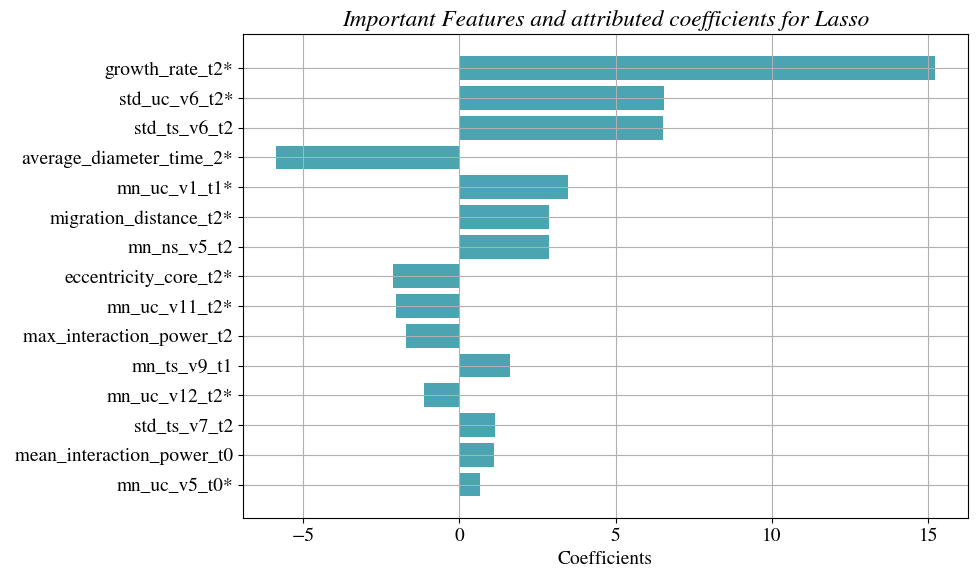

In [30]:
model_str = 'Lasso'
nb_timesteps=3
nb_selected=15
path_model='/work/bb1153/b381993/data/FINAL_VERSION_new/saved_models/'
df_train=df_train
            
plot_features_importance(model_str, nb_selected, path_model, df_train, nb_timesteps, automatic_name=True)

In [31]:
features_selected_names_lasso, values_features_lasso, index_argsort_lasso = get_features_importance(path_model='/work/bb1153/b381993/data/FINAL_VERSION_new/saved_models/',
                        model_str='Lasso',
                        df_train=df_train,
                        nb_timesteps=3)

In [32]:
nb_timesteps

3

In [33]:
features_selected_names_lasso[:15]
nice_names_for_plot = ['growth rate*', 'std IWP*','std IWP (total)', 'equivalent diameter*', 'mean LWNTA*', 
                       'migration distance', 'mean surface temp. of neighbors', 'eccentricity (core)', 'mean OM700Pa*',
                       'interaction with neighbors (max)','landmask', 'mean OM850hPa*', 'std U10m', 
                       'interaction with neighbors (mean)', 'mean surface temperature*'
                      ] 

dict_for_plot = pd.DataFrame({'previous_name':features_selected_names_lasso[:15], 'new_nice_name':nice_names_for_plot})

In [34]:
dict_for_plot

previous_name  \
0                         gradient_area_time_2   
1                 std_under_cloud_var_6_time_2   
2                  std_everywhere_var_6_time_2   
3                      average_diameter_time_2   
4                mean_under_cloud_var_1_time_1   
5                        migration_dist_time_2   
6   mean_under_all_mcs_neighbours_var_5_time_2   
7                      eccentricity_172_time_2   
8               mean_under_cloud_var_11_time_2   
9                 max_interaction_power_time_2   
10                mean_everywhere_var_9_time_1   
11              mean_under_cloud_var_12_time_2   
12                 std_everywhere_var_7_time_2   
13               mean_interaction_power_time_0   
14               mean_under_cloud_var_5_time_0   

                        new_nice_name  
0                        growth rate*  
1                            std IWP*  
2                     std IWP (total)  
3                equivalent diameter*  
4                         mean LWNTA*  
5                  migration distance  
6     mean surface temp. of neighbors  
7                 eccentricity (core)  
8                       mean OM700Pa*  
9    interaction with neighbors (max)  
10                           landmask  
11                     mean OM850hPa*  
12                           std U10m  
13  interaction with neighbors (mean)  
14          mean surface temperature*

In [35]:
new_name_features_selected= [df_names[df_names['Old Name']==features_selected_names_lasso[:15][i]]['Name Plot'].values[0] for i in range(15)]


In [36]:
new_name_features_selected2= [dict_for_plot[dict_for_plot['previous_name']==features_selected_names_lasso[:15][i]]['new_nice_name'].values[0] for i in range(15)]


In [37]:
new_name_features_selected2

['growth rate*',
 'std IWP*',
 'std IWP (total)',
 'equivalent diameter*',
 'mean LWNTA*',
 'migration distance',
 'mean surface temp. of neighbors',
 'eccentricity (core)',
 'mean OM700Pa*',
 'interaction with neighbors (max)',
 'landmask',
 'mean OM850hPa*',
 'std U10m',
 'interaction with neighbors (mean)',
 'mean surface temperature*']

In [38]:
from sklearn.preprocessing import StandardScaler

df_train_cut = df_train[features_selected_names_lasso[:15]]
scaler = StandardScaler().fit(df_train_cut.values)
X_train = scaler.transform(df_train_cut.values)
y_train = df_train['y_max_extend']


In [39]:

idx_sys = np.array(['*' in item for item in new_name_features_selected])

sys = np.where(idx_sys)[0]
env = np.where(~idx_sys)[0]

new_name_features_selected = np.array(new_name_features_selected)
print(new_name_features_selected[sys])
print(new_name_features_selected[env])

coef_i =values_features_lasso[:15]

aa=0
for idx_sys in sys:
    aa+=coef_i[idx_sys]*X_train[:,idx_sys]
    
bb=0
for idx_env in env:
    bb+=coef_i[idx_env]*X_train[:,idx_env]

['growth_rate_t2*' 'std_uc_v6_t2*' 'average_diameter_time_2*'
 'mn_uc_v1_t1*' 'migration_distance_t2*' 'eccentricity_core_t2*'
 'mn_uc_v11_t2*' 'mn_uc_v12_t2*' 'mn_uc_v5_t0*']
['std_ts_v6_t2' 'mn_ns_v5_t2' ' max_interaction_power_t2' 'mn_ts_v9_t1'
 'std_ts_v7_t2' ' mean_interaction_power_t0']


In [40]:
import seaborn as sns
import cmocean
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(9,11), constrained_layout=True)
gs = GridSpec(110, 130, figure=fig)
ax1 = fig.add_subplot(gs[30:35, :125])
ax2 = fig.add_subplot(gs[10:35, 129:])
ax3 = fig.add_subplot(gs[37:110, :])



data = np.array([values_features_lasso[:15]])

sns.heatmap(data,annot=True, cmap='RdYlBu', vmin=-10, vmax=10, fmt=".1f", linewidth=.5, cbar_ax=ax2, ax=ax1, cbar_kws={'label': 'Linear coefficients [1]', 'aspect':'110', 'orientation':'vertical', 'shrink':'0.6',  'extend':'both'}
        )



ax1.xaxis.tick_top()
ax1.set_xticks(np.arange(data.shape[1]) + 0.3, new_name_features_selected2[:15], rotation=80, ha='left')


ax1.get_yaxis().set_visible(False)






color=y_train
cmap=plt.get_cmap('YlGnBu',10)
im = ax3.scatter(aa, bb, c = color, cmap=cmap, marker='+')
im.set_clim(40, 220)



ax3.set_xlim(-55,100)
#ax3.set_ylim(-15,20)

ax3.set_xlabel('System features collected*')
ax3.set_ylabel('Environment features collected')
fig.colorbar(im, orientation='horizontal', label='Maximal extension [km]', aspect=110, pad=0.15, ax=ax3,)
plt.grid(True)


# Assuming you have your axes already created as ax1, ax2, and ax3
labels = ['A.', 'B.']
pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
pnas_text_color = '#0033a0'  # PNAS dark blue color for text

for i, ax_subi in enumerate([ax1, ax3]):
    if ax_subi == ax1:
        ax_subi.text(
        0.02, 4.5, labels[i], 
        transform=ax_subi.transAxes, 
        weight='bold',
        color=pnas_text_color,  # Text color
        bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
        )
    else:
        ax_subi.text(
        0.02, 0.93, labels[i], 
        transform=ax_subi.transAxes, 
        weight='bold',
        color=pnas_text_color,  # Text color
        bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
        )



path_to_save = os.path.join(path_figures, 'figure_4.pdf')
plt.savefig(path_to_save)

In [41]:
idx_small = np.where(df_train['y_max_extend'].values<120)[0]
idx_big = np.where(df_train['y_max_extend'].values>=120)[0]
X_train_small = X_train[idx_small, :]
X_train_big = X_train[idx_big, :]

In [42]:

coef_i =values_features_lasso[:15]

sum_sys_small=0
for idx_sys in sys:
    sum_sys_small+=coef_i[idx_sys]*X_train_small[:,idx_sys]
    
sum_env_small=0
for idx_env in env:
    sum_env_small+=coef_i[idx_env]*X_train_small[:,idx_env]

In [43]:

coef_i =values_features_lasso[:15]

sum_sys_big=0
for idx_sys in sys:
    sum_sys_big+=coef_i[idx_sys]*X_train_big[:,idx_sys]
    
sum_env_big=0
for idx_env in env:
    sum_env_big+=coef_i[idx_env]*X_train_big[:,idx_env]

In [44]:

coef_i =values_features_lasso[:15]

sum_sys_all=0
for idx_sys in sys:
    sum_sys_all+=coef_i[idx_sys]*X_train[:,idx_sys]
    
sum_env_all=0
for idx_env in env:
    sum_env_all+=coef_i[idx_env]*X_train[:,idx_env]

In [45]:
fig, ax = plt.subplots(1,3, figsize=(16,5), constrained_layout=True)
colors = [plt.get_cmap('GnBu',10)(1), plt.get_cmap('GnBu',10)(5), plt.get_cmap('GnBu',10)(9)]

X = np.stack((sum_sys_all, sum_env_all), axis=0)
co_var = np.cov(X)[0,1]
var_sys, var_env, double_co_var = np.var(sum_sys_all), np.var(sum_env_all), 2*co_var


labels = ['System', 'Environment', 'Both']
sizes = [var_sys, var_env, double_co_var]  # percentages or values

size = 0.3
# Create a pie chart
ax[0].pie(sizes,  autopct='%1.1f%%', startangle=90, colors=colors,
       wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85,
            labeldistance=1.1,
            textprops={'color':"k", 'fontsize': 14} )

ax[0].axis('equal') 
ax[0].legend(labels=['System', 'Environment', 'Co-variance'], loc='center', prop={'size': 15})
ax[0].set_title('All systems')

########
X = np.stack((sum_sys_small, sum_env_small), axis=0)
co_var = np.cov(X)[0,1]
var_sys, var_env, double_co_var = np.var(sum_sys_small), np.var(sum_env_small), 2*co_var

labels = ['System', 'Environment', 'Co-variance']
sizes = [var_sys, var_env, double_co_var]  # percentages or values


size = 0.3
ax[1].pie(sizes, autopct='%1.1f%%', startangle=90, colors=colors,
       wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85,
            labeldistance=1.1,
            textprops={'color':"k", 'fontsize': 14} )

ax[1].axis('equal') 
ax[1].legend(labels=['System', 'Environment', 'Co-variance'], loc='center', prop={'size': 15})
ax[1].set_title('Small systems (<120km)')


###########
X = np.stack((sum_sys_big, sum_env_big), axis=0)
co_var = np.cov(X)[0,1]
var_sys, var_env, double_co_var = np.var(sum_sys_big), np.var(sum_env_big), 2*co_var

labels = ['System', 'Environment', 'Co-variance']
sizes = [var_sys, var_env, double_co_var]  # percentages or values

# Create a pie chart
ax[2].pie(sizes, autopct='%1.1f%%', startangle=90, colors=colors,
       wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85,
            labeldistance=1.1,
            textprops={'color':"k", 'fontsize': 14})

ax[2].axis('equal') 
ax[2].legend(labels=['System', 'Environment', 'Co-variance'], loc='center', prop={'size': 15})
ax[2].set_title('Large systems (>120km)')


# Assuming you have your axes already created as ax1, ax2, and ax3
labels = ['A.', 'B.', 'C.']
pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
pnas_text_color = '#0033a0'  # PNAS dark blue color for text

for i, ax_subi in enumerate([ax[0], ax[1], ax[2]]):
    ax_subi.text(
        0.02, 0.93, labels[i], 
        transform=ax_subi.transAxes, 
        weight='bold',
        color=pnas_text_color,  # Text color
        bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
    )

path_to_save = os.path.join(path_figures, 'figure_5.pdf')
plt.savefig(path_to_save)

In [50]:
###new test

value_threshold = 80
idx_small = np.where(df_train['y_max_extend'].values<value_threshold)[0]
idx_big = np.where(df_train['y_max_extend'].values>=value_threshold)[0]
X_train_small = X_train[idx_small, :]
X_train_big = X_train[idx_big, :]



coef_i =values_features_lasso[:15]

sum_sys_small=0
for idx_sys in sys:
    sum_sys_small+=coef_i[idx_sys]*X_train_small[:,idx_sys]
    
sum_env_small=0
for idx_env in env:
    sum_env_small+=coef_i[idx_env]*X_train_small[:,idx_env]


coef_i =values_features_lasso[:15]

sum_sys_big=0
for idx_sys in sys:
    sum_sys_big+=coef_i[idx_sys]*X_train_big[:,idx_sys]
    
sum_env_big=0
for idx_env in env:
    sum_env_big+=coef_i[idx_env]*X_train_big[:,idx_env]


coef_i =values_features_lasso[:15]

sum_sys_all=0
for idx_sys in sys:
    sum_sys_all+=coef_i[idx_sys]*X_train[:,idx_sys]
    
sum_env_all=0
for idx_env in env:
    sum_env_all+=coef_i[idx_env]*X_train[:,idx_env]

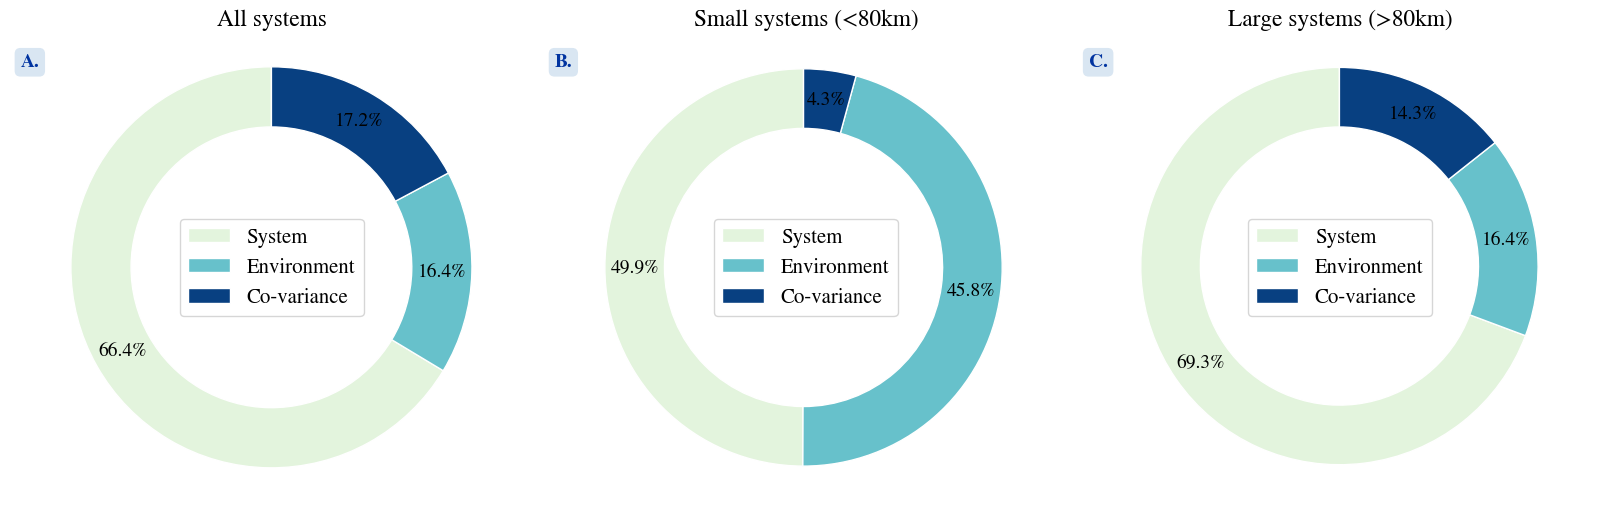

In [51]:
fig, ax = plt.subplots(1,3, figsize=(16,5), constrained_layout=True)
colors = [plt.get_cmap('GnBu',10)(1), plt.get_cmap('GnBu',10)(5), plt.get_cmap('GnBu',10)(9)]

X = np.stack((sum_sys_all, sum_env_all), axis=0)
co_var = np.cov(X)[0,1]
var_sys, var_env, double_co_var = np.var(sum_sys_all), np.var(sum_env_all), 2*co_var


labels = ['System', 'Environment', 'Both']
sizes = [var_sys, var_env, double_co_var]  # percentages or values

size = 0.3
# Create a pie chart
ax[0].pie(sizes,  autopct='%1.1f%%', startangle=90, colors=colors,
       wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85,
            labeldistance=1.1,
            textprops={'color':"k", 'fontsize': 14} )

ax[0].axis('equal') 
ax[0].legend(labels=['System', 'Environment', 'Co-variance'], loc='center', prop={'size': 15})
ax[0].set_title('All systems')

########
X = np.stack((sum_sys_small, sum_env_small), axis=0)
co_var = np.cov(X)[0,1]
var_sys, var_env, double_co_var = np.var(sum_sys_small), np.var(sum_env_small), 2*co_var

labels = ['System', 'Environment', 'Co-variance']
sizes = [var_sys, var_env, double_co_var]  # percentages or values


size = 0.3
ax[1].pie(sizes, autopct='%1.1f%%', startangle=90, colors=colors,
       wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85,
            labeldistance=1.1,
            textprops={'color':"k", 'fontsize': 14} )

ax[1].axis('equal') 
ax[1].legend(labels=['System', 'Environment', 'Co-variance'], loc='center', prop={'size': 15})
ax[1].set_title(f'Small systems (<{value_threshold}km)')


###########
X = np.stack((sum_sys_big, sum_env_big), axis=0)
co_var = np.cov(X)[0,1]
var_sys, var_env, double_co_var = np.var(sum_sys_big), np.var(sum_env_big), 2*co_var

labels = ['System', 'Environment', 'Co-variance']
sizes = [var_sys, var_env, double_co_var]  # percentages or values

# Create a pie chart
ax[2].pie(sizes, autopct='%1.1f%%', startangle=90, colors=colors,
       wedgeprops=dict(width=size, edgecolor='w'),
            pctdistance=0.85,
            labeldistance=1.1,
            textprops={'color':"k", 'fontsize': 14})

ax[2].axis('equal') 
ax[2].legend(labels=['System', 'Environment', 'Co-variance'], loc='center', prop={'size': 15})
ax[2].set_title(f'Large systems (>{value_threshold}km)')


# Assuming you have your axes already created as ax1, ax2, and ax3
labels = ['A.', 'B.', 'C.']
pnas_bg_color = '#d9e6f2'  # PNAS light blue color for background
pnas_text_color = '#0033a0'  # PNAS dark blue color for text

for i, ax_subi in enumerate([ax[0], ax[1], ax[2]]):
    ax_subi.text(
        0.02, 0.93, labels[i], 
        transform=ax_subi.transAxes, 
        weight='bold',
        color=pnas_text_color,  # Text color
        bbox=dict(facecolor=pnas_bg_color, edgecolor='none', boxstyle='round,pad=0.3')  # Background color with padding
    )

#path_to_save = os.path.join(path_figures, 'figure_5.pdf')
#plt.savefig(path_to_save)

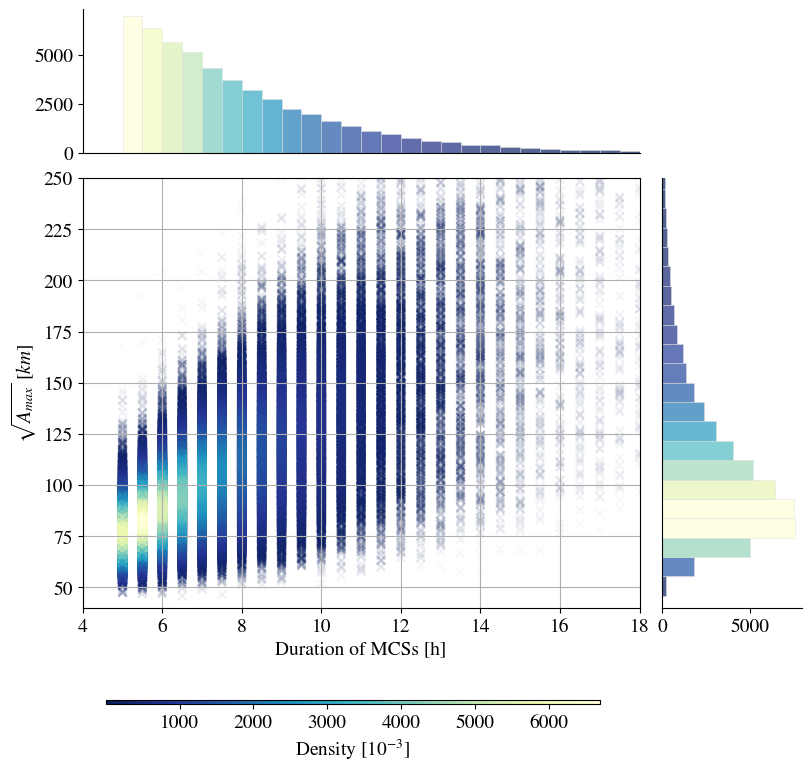

In [46]:
fig = plt.figure(layout="constrained",  figsize=(8,8))

gs = GridSpec(10,10, figure=fig)

ax_histx = fig.add_subplot(gs[:2, :-2])
ax = fig.add_subplot(gs[2:-2, :-2])
ax_histy = fig.add_subplot(gs[2:-2, -2:])
cbax = fig.add_subplot(gs[-2:,:-2])

#DATA
duration_list, surf_list = df_train['y_duration'], df_train['y_max_extend']

#DENSITY
x=duration_list
y = surf_list
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

#PLOT AX
im = ax.scatter(duration_list, surf_list, c=1000*1000*z, marker='x', alpha=(z/np.max(z))**0.5, cmap='YlGnBu_r')
#im = ax.hexbin(duration_list, surf_list, gridsize=30,alpha=0.7, cmap='YlGnBu', vmin=0, vmax=500, mincnt=5)

#PLOT HIST + color custom
n, bins, patches = ax_histx.hist(df_train['y_duration'], bins=np.linspace(min(df_train['y_duration']), 22, 35), facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n = n.astype('int') # it MUST be integer
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.YlGnBu_r(n[i]/max(n)))
    #patches[i].set_facecolor(plt.cm.YlGnBu_r(n[i]/np.sum(n)))

n, bins, patches = ax_histy.hist(df_train['y_max_extend'], bins=np.linspace(min(df_train['y_max_extend']), max(df_train['y_max_extend']), 60), facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7, orientation='horizontal')
n = n.astype('int') # it MUST be integer
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.YlGnBu_r(n[i]/max(n)))
    

#ADD COLORBAR
fig.colorbar(im, orientation='horizontal', label=r'Density [$10^{-3}$]', aspect=110, ax=cbax)

#NICE PLOT RECIPE
cbax.remove() #remove ax boundary around the colorbar

ax.set_xlabel('Duration of MCSs [h]')
ax.set_ylabel(r'$\sqrt{A_{max}}$ [$km$]')
ax.grid(True)
ax.set_xlim(4,18)
ax.set_ylim(40,250)

ax_histx.set_xlim(4,18)
ax_histy.set_ylim(40,250)

ax_histx.set_xticks([])
ax_histy.set_yticks([])
ax_histx.spines[['right', 'top']].set_visible(False)
ax_histy.spines[['right', 'top']].set_visible(False)


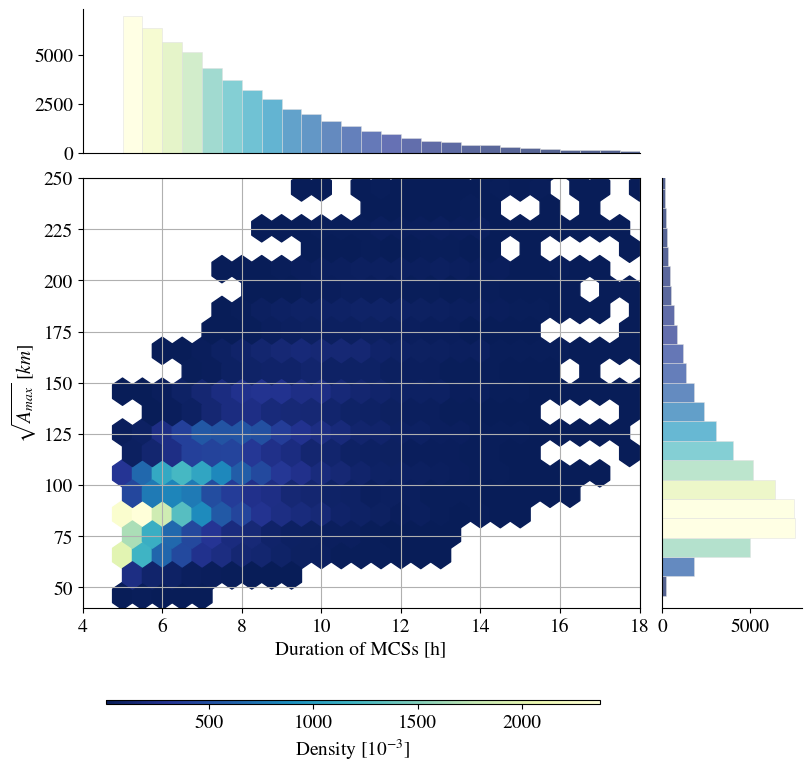

In [47]:
fig = plt.figure(layout="constrained",  figsize=(8,8))

gs = GridSpec(10,10, figure=fig)

ax_histx = fig.add_subplot(gs[:2, :-2])
ax = fig.add_subplot(gs[2:-2, :-2])
ax_histy = fig.add_subplot(gs[2:-2, -2:])
cbax = fig.add_subplot(gs[-2:,:-2])
#DATA
duration_list, surf_list = df_train['y_duration'], df_train['y_max_extend']

#PLOT AX
im = ax.hexbin(duration_list, surf_list, gridsize=50, cmap='YlGnBu_r', mincnt=5)

#PLOT HIST + color custom
n, bins, patches = ax_histx.hist(df_train['y_duration'], bins=np.linspace(min(df_train['y_duration']), 22, 35), facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n = n.astype('int') # it MUST be integer
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.YlGnBu_r(n[i]/max(n)))
    #patches[i].set_facecolor(plt.cm.YlGnBu_r(n[i]/np.sum(n)))

n, bins, patches = ax_histy.hist(df_train['y_max_extend'], bins=np.linspace(min(df_train['y_max_extend']), max(df_train['y_max_extend']), 60), facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7, orientation='horizontal')
n = n.astype('int') # it MUST be integer
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.YlGnBu_r(n[i]/max(n)))
    

#ADD COLORBAR
fig.colorbar(im, orientation='horizontal', label=r'Density [$10^{-3}$]', aspect=110, ax=cbax)

#NICE PLOT RECIPE
cbax.remove() #remove ax boundary around the colorbar

ax.set_xlabel('Duration of MCSs [h]')
ax.set_ylabel(r'$\sqrt{A_{max}}$ [$km$]')
ax.grid(True)
ax.set_xlim(4,18)
ax.set_ylim(40,250)

ax_histx.set_xlim(4,18)
ax_histy.set_ylim(40,250)

ax_histx.set_xticks([])
ax_histy.set_yticks([])
ax_histx.spines[['right', 'top']].set_visible(False)
ax_histy.spines[['right', 'top']].set_visible(False)


In [58]:
np.mean(df_train['y_duration'].values)

7.697798158037304